In [1]:
import pandas as pd

df = pd.read_csv('../data/SisFall_train.csv')

print(df)

       user_ID trial_ID task_ID         gx         gy         gz   
0         SA01      R01     D01  -1.098633 -30.761719 -21.484375  \
1         SA01      R01     D01 -10.864258 -46.752930  -3.173828   
2         SA01      R01     D01  31.860352 -22.216797   8.056641   
3         SA01      R01     D01   2.624512 -11.352539  29.052734   
4         SA01      R01     D01   7.263184  15.869141  26.184082   
...        ...      ...     ...        ...        ...        ...   
300097    SE14      R06     D07  -3.479004   2.563477  -0.061035   
300098    SE14      R06     D07  -2.197266   3.234863   0.488281   
300099    SE14      R06     D07  -4.394531   2.990723   0.549316   
300100    SE14      R06     D07  -2.746582   2.563477   0.000000   
300101    SE14      R06     D07  -4.028320   2.258301   0.122070   

                   label  scaled_gx  scaled_gy  scaled_gz  
0                walking  -0.284779  -0.036755   0.042287  
1                walking  -0.291049  -0.056733   0.066825  
2  

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# 데이터셋 준비
X = []  # 입력 데이터
y = []  # 출력 데이터

# 4개의 레코드씩 묶어서 처리
for i in range(0, len(df) - 3, 4):
    # gx, gy, gz 값 가져오기
    gx_values = df.loc[i:i+3, 'scaled_gx'].values
    gy_values = df.loc[i:i+3, 'scaled_gy'].values
    gz_values = df.loc[i:i+3, 'scaled_gz'].values

    # 레이블 값 가져오기
    labels = df.loc[i:i+3, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X.append([gx_values, gy_values, gz_values])

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y.append(labels[0])

# 입력 데이터와 출력 데이터를 넘파이 배열로 변환
X = np.array(X)
y = np.array(y)

# 출력 데이터를 One-Hot 인코딩
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y)
onehot_encoder = OneHotEncoder(sparse_output=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y = onehot_encoder.fit_transform(integer_encoded)

In [3]:
from tensorflow import keras

# LSTM 모델 정의
model = keras.models.Sequential()
model.add(keras.layers.LSTM(128, input_shape=(3, 4)))  # 3개의 시퀀스, 각 시퀀스에 4개의 피처
model.add(keras.layers.Dense(5, activation='softmax'))  # 분류할 클래스 수에 맞게 조정

# 모델 컴파일 및 학습
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X, y, epochs=100, batch_size=32)

Epoch 1/100
2342/2342 [==============================] - 6s 2ms/step - loss: 1.5844 - accuracy: 0.2607
Epoch 2/100
2342/2342 [==============================] - 4s 2ms/step - loss: 1.3840 - accuracy: 0.3831
Epoch 3/100
2342/2342 [==============================] - 5s 2ms/step - loss: 1.2626 - accuracy: 0.4300
Epoch 4/100
2342/2342 [==============================] - 5s 2ms/step - loss: 1.1710 - accuracy: 0.4752
Epoch 5/100
2342/2342 [==============================] - 5s 2ms/step - loss: 1.1174 - accuracy: 0.5034
Epoch 6/100
2342/2342 [==============================] - 5s 2ms/step - loss: 1.0866 - accuracy: 0.5158
Epoch 7/100
2342/2342 [==============================] - 5s 2ms/step - loss: 1.0637 - accuracy: 0.5273
Epoch 8/100
2342/2342 [==============================] - 5s 2ms/step - loss: 1.0395 - accuracy: 0.5394
Epoch 9/100
2342/2342 [==============================] - 5s 2ms/step - loss: 1.0027 - accuracy: 0.5595
Epoch 10/100
2342/2342 [==============================] - 4s 2ms/step - l

In [18]:
import pickle

# 최상의 적합 모델의 가중치를 피클 파일로 저장
best_model_weights = history.model.get_weights()
pickle.dump(best_model_weights, open('../model/best_model_weights.pkl', 'wb'))

# 레이블 인코더의 클래스 정보를 저장
np.save('../model/label_encoder_classes.npy', label_encoder.classes_)

In [19]:
from tensorflow import keras
import pickle

# Define the Loaded Model
loaded_model = keras.models.Sequential()
loaded_model.add(keras.layers.LSTM(128, input_shape=(3, 4)))
loaded_model.add(keras.layers.Dense(5, activation='softmax'))

# Load the Model Weights
loaded_model_weights = pickle.load(open('../model/best_model_weights.pkl', 'rb'))
loaded_model.set_weights(loaded_model_weights)

In [20]:
# Compile the Loaded Model
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Save the Loaded Model
loaded_model.save('../model/loaded_model.h5')

In [22]:
# Load the data for prediction
pred_df = pd.read_csv('../data/Arduino/fall_sc.csv')
X_pred = []

# Prepare the data for prediction
for i in range(0, len(pred_df) - 3, 4):
    gx_values = pred_df.loc[i:i+3, 'scaled_gx'].values
    gy_values = pred_df.loc[i:i+3, 'scaled_gy'].values
    gz_values = pred_df.loc[i:i+3, 'scaled_gz'].values
    X_pred.append([gx_values, gy_values, gz_values])

X_pred = np.array(X_pred)

# Load the Trained Model and Make Predictions
try:
    best_model = keras.models.load_model('../model/loaded_model.h5')
except FileNotFoundError as e:
    print(f"모델 파일을 찾을 수 없습니다: {e}")
    exit()

predictions = best_model.predict(X_pred)

# Decode and Store the Predictions
label_encoder = LabelEncoder()
label_encoder.classes_ = np.load('../model/label_encoder_classes.npy')
decoded_predictions = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

pred_df['predicted_label'] = np.repeat(decoded_predictions, 4)
pred_df.to_csv('../data/prediction_results.csv', index=False)

# 예측
predictions = loaded_model.predict(X_pred)
predicted_labels = np.argmax(predictions, axis=1)
predicted_classes = label_encoder.inverse_transform(predicted_labels)

# 예측 결과 출력
print(predicted_classes)

2/2 [==============================] - 0s 0s/step
['fall' 'jogging' 'jogging' 'stairs_walking' 'stairs_walking' 'fall'
 'stairs_walking' 'fall' 'stairs_walking' 'stairs_walking'
 'stairs_walking' 'fall' 'fall' 'fall' 'fall' 'fall' 'fall' 'fall' 'fall'
 'stairs_walking' 'jogging' 'fall' 'stairs_walking' 'stairs_walking'
 'fall' 'fall' 'fall' 'jogging' 'stairs_walking' 'fall' 'fall'
 'stairs_walking' 'fall' 'fall' 'jogging' 'jogging' 'fall' 'fall'
 'stairs_walking' 'jogging' 'stairs_walking' 'fall' 'jogging' 'fall'
 'fall' 'stairs_walking' 'fall' 'fall' 'fall' 'fall']


In [38]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# 데이터셋 준비
X = []  # 입력 데이터
y = []  # 출력 데이터

# 40개의 레코드씩 묶어서 처리
for i in range(0, len(df) - 39, 40):
    # gx, gy, gz 값 가져오기
    gx_values = df.loc[i:i+39, 'scaled_gx'].values
    gy_values = df.loc[i:i+39, 'scaled_gy'].values
    gz_values = df.loc[i:i+39, 'scaled_gz'].values

    # 레이블 값 가져오기
    labels = df.loc[i:i+39, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X.append([gx_values, gy_values, gz_values])

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y.append(labels[0])

# 입력 데이터와 출력 데이터를 넘파이 배열로 변환
X = np.array(X)
y = np.array(y)

# 출력 데이터를 One-Hot 인코딩
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y)
onehot_encoder = OneHotEncoder(sparse_output=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y = onehot_encoder.fit_transform(integer_encoded)


In [39]:
X = np.transpose(X, (0, 2, 1))  # 입력 데이터의 축 순서 변경

# LSTM 모델 정의
model = keras.models.Sequential()
model.add(keras.layers.LSTM(128, input_shape=(40, 3)))  # 40개의 시퀀스, 각 시퀀스에 3개의 피처
model.add(keras.layers.Dense(5, activation='softmax'))  # 분류할 클래스 수에 맞게 조정

# 모델 컴파일 및 학습
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X, y, epochs=100, batch_size=32)


Epoch 1/100
256/256 [==============================] - 5s 14ms/step - loss: 1.5560 - accuracy: 0.2877
Epoch 2/100
256/256 [==============================] - 4s 14ms/step - loss: 1.5522 - accuracy: 0.2877
Epoch 3/100
256/256 [==============================] - 4s 14ms/step - loss: 1.5502 - accuracy: 0.2877
Epoch 4/100
256/256 [==============================] - 4s 14ms/step - loss: 1.5498 - accuracy: 0.2877
Epoch 5/100
256/256 [==============================] - 4s 14ms/step - loss: 1.5494 - accuracy: 0.2861
Epoch 6/100
256/256 [==============================] - 4s 14ms/step - loss: 1.5463 - accuracy: 0.2915
Epoch 7/100
256/256 [==============================] - 4s 14ms/step - loss: 1.5193 - accuracy: 0.3295
Epoch 8/100
256/256 [==============================] - 4s 14ms/step - loss: 1.2886 - accuracy: 0.4414
Epoch 9/100
256/256 [==============================] - 4s 14ms/step - loss: 1.1097 - accuracy: 0.5001
Epoch 10/100
256/256 [==============================] - 4s 14ms/step - loss: 1.048

In [40]:
import pickle

# 최상의 적합 모델의 가중치를 피클 파일로 저장
best_model_weights = history.model.get_weights()
pickle.dump(best_model_weights, open('../model/best_model_weights.pkl', 'wb'))

# 레이블 인코더의 클래스 정보를 저장
np.save('../model/label_encoder_classes.npy', label_encoder.classes_)

In [41]:
from tensorflow import keras
import pickle

# Define the Loaded Model
loaded_model = keras.models.Sequential()
loaded_model.add(keras.layers.LSTM(128, input_shape=(40, 3)))  # 입력 형태 수정
loaded_model.add(keras.layers.Dense(5, activation='softmax'))

# Load the Model Weights
loaded_model_weights = pickle.load(open('../model/best_model_weights.pkl', 'rb'))
loaded_model.set_weights(loaded_model_weights)


In [43]:
#Compile the Loaded Model
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Save the Loaded Model
loaded_model.save('../model/loaded_model.h5')

In [44]:
# Load the data for prediction
pred_df = pd.read_csv('../data/Arduino/fall_sc.csv')

# Prepare the data for prediction
X_pred = []
for i in range(0, len(pred_df) - 39, 40):
    gx_values = pred_df.loc[i:i+39, 'scaled_gx'].values.reshape((40, 1))
    gy_values = pred_df.loc[i:i+39, 'scaled_gy'].values.reshape((40, 1))
    gz_values = pred_df.loc[i:i+39, 'scaled_gz'].values.reshape((40, 1))
    X_pred.append(np.concatenate((gx_values, gy_values, gz_values), axis=1))

X_pred = np.array(X_pred)

# Load the Trained Model and Make Predictions
try:
    loaded_model = keras.models.load_model('../model/loaded_model.h5')
except FileNotFoundError as e:
    print(f"모델 파일을 찾을 수 없습니다: {e}")
    exit()

predictions = loaded_model.predict(X_pred)

# Decode and Store the Predictions
label_encoder = LabelEncoder()
label_encoder.classes_ = np.load('../model/label_encoder_classes.npy')
decoded_predictions = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

# 예측 결과 출력
print(decoded_predictions)


1/1 [==============================] - 1s 603ms/step
['fall' 'fall' 'fall' 'stairs_walking' 'fall']


In [45]:
# Load the data for prediction
pred_df = pd.read_csv('../data/Arduino/walking_sc.csv')

# Prepare the data for prediction
X_pred = []
for i in range(0, len(pred_df) - 39, 40):
    gx_values = pred_df.loc[i:i+39, 'scaled_gx'].values.reshape((40, 1))
    gy_values = pred_df.loc[i:i+39, 'scaled_gy'].values.reshape((40, 1))
    gz_values = pred_df.loc[i:i+39, 'scaled_gz'].values.reshape((40, 1))
    X_pred.append(np.concatenate((gx_values, gy_values, gz_values), axis=1))

X_pred = np.array(X_pred)

# Load the Trained Model and Make Predictions
try:
    loaded_model = keras.models.load_model('../model/loaded_model.h5')
except FileNotFoundError as e:
    print(f"모델 파일을 찾을 수 없습니다: {e}")
    exit()

predictions = loaded_model.predict(X_pred)

# Decode and Store the Predictions
label_encoder = LabelEncoder()
label_encoder.classes_ = np.load('../model/label_encoder_classes.npy')
decoded_predictions = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

# 예측 결과 출력
print(decoded_predictions)


1/1 [==============================] - 1s 538ms/step
['jogging' 'jogging' 'fall' 'fall' 'jogging' 'fall' 'fall' 'fall' 'fall'
 'stairs_walking']


In [46]:
# Load the data for prediction
pred_df = pd.read_csv('../data/Arduino/standing_sc.csv')

# Prepare the data for prediction
X_pred = []
for i in range(0, len(pred_df) - 39, 40):
    gx_values = pred_df.loc[i:i+39, 'scaled_gx'].values.reshape((40, 1))
    gy_values = pred_df.loc[i:i+39, 'scaled_gy'].values.reshape((40, 1))
    gz_values = pred_df.loc[i:i+39, 'scaled_gz'].values.reshape((40, 1))
    X_pred.append(np.concatenate((gx_values, gy_values, gz_values), axis=1))

X_pred = np.array(X_pred)

# Load the Trained Model and Make Predictions
try:
    loaded_model = keras.models.load_model('../model/loaded_model.h5')
except FileNotFoundError as e:
    print(f"모델 파일을 찾을 수 없습니다: {e}")
    exit()

predictions = loaded_model.predict(X_pred)

# Decode and Store the Predictions
label_encoder = LabelEncoder()
label_encoder.classes_ = np.load('../model/label_encoder_classes.npy')
decoded_predictions = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

# 예측 결과 출력
print(decoded_predictions)


1/1 [==============================] - 1s 531ms/step
['fall' 'fall' 'stairs_walking' 'jogging' 'fall' 'fall']


In [3]:
import numpy as np
import pandas as pd
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import pickle

# 데이터셋 준비
train_df = pd.read_csv('../data/SisFall_train.csv')  # 훈련 파일
test_df = pd.read_csv('../data/SisFall_test.csv')  # 테스트 파일

X_train = []  # 훈련 입력 데이터
y_train = []  # 훈련 출력 데이터

X_test = []  # 테스트 입력 데이터
y_test = []  # 테스트 출력 데이터

# 4개의 레코드씩 묶어서 처리
for i in range(0, len(train_df) - 39, 40):
    # gx, gy, gz 값 가져오기
    gx_values = train_df.loc[i:i+39, 'gx'].values
    gy_values = train_df.loc[i:i+39, 'gy'].values
    gz_values = train_df.loc[i:i+39, 'gz'].values

    # 레이블 값 가져오기
    labels = train_df.loc[i:i+39, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X_train.append([gx_values, gy_values, gz_values])

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y_train.append(labels[0])

for i in range(0, len(test_df) - 39, 40):
    # gx, gy, gz 값 가져오기
    gx_values = test_df.loc[i:i+39, 'gx'].values
    gy_values = test_df.loc[i:i+39, 'gy'].values
    gz_values = test_df.loc[i:i+39, 'gz'].values

    # 레이블 값 가져오기
    labels = test_df.loc[i:i+39, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X_test.append([gx_values, gy_values, gz_values])

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y_test.append(labels[0])

# 입력 데이터와 출력 데이터를 넘파이 배열로 변환
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

# 출력 데이터를 One-Hot 인코딩
label_encoder = LabelEncoder()
integer_encoded_train = label_encoder.fit_transform(y_train)
integer_encoded_train = integer_encoded_train.reshape(len(integer_encoded_train), 1)
onehot_encoder = OneHotEncoder(sparse_output=False)
y_train = onehot_encoder.fit_transform(integer_encoded_train)

integer_encoded_test = label_encoder.transform(y_test)
integer_encoded_test = integer_encoded_test.reshape(len(integer_encoded_test), 1)
y_test = onehot_encoder.transform(integer_encoded_test)

# LSTM 모델 정의
model = keras.models.Sequential()
model.add(keras.layers.LSTM(128, input_shape=(3, 40)))  # 3개의 시퀀스, 각 시퀀스에 40개의 피처
model.add(keras.layers.Dense(5, activation='softmax'))  # 분류할 클래스 수에 맞게 조정

# 모델 컴파일 및 학습
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# 최상의 적합 모델의 가중치를 피클 파일로 저장
best_model_weights = history.model.get_weights()
pickle.dump(best_model_weights, open('../model/best_model_weights_lstm.pkl', 'wb'))

# 레이블 인코더의 클래스 정보를 저장
np.save('../model/label_encoder_classes_lstm.npy', label_encoder.classes_)

# 가중치를 로드하기 위해 모델 구성
loaded_model = keras.models.Sequential()
loaded_model.add(keras.layers.LSTM(128, input_shape=(3, 40)))  # 3개의 시퀀스, 각 시퀀스에 40개의 피처
loaded_model.add(keras.layers.Dense(5, activation='softmax'))  # 분류할 클래스 수에 맞게 조정

# 피클 파일에서 가중치 로드
loaded_model_weights = pickle.load(open('../model/best_model_weights_lstm.pkl', 'rb'))

# 모델에 로드된 가중치 설정
loaded_model.set_weights(loaded_model_weights)

# 모델 컴파일
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 저장
loaded_model.save('../model/loaded_model_lstm.h5')

Epoch 1/10
174/174 [==============================] - 2s 5ms/step - loss: 1.0991 - accuracy: 0.5882 - val_loss: 0.8333 - val_accuracy: 0.6988
Epoch 2/10
174/174 [==============================] - 0s 2ms/step - loss: 0.6242 - accuracy: 0.7806 - val_loss: 0.6666 - val_accuracy: 0.7547
Epoch 3/10
174/174 [==============================] - 0s 2ms/step - loss: 0.4608 - accuracy: 0.8336 - val_loss: 0.6055 - val_accuracy: 0.7680
Epoch 4/10
174/174 [==============================] - 0s 2ms/step - loss: 0.3590 - accuracy: 0.8765 - val_loss: 0.5616 - val_accuracy: 0.7841
Epoch 5/10
174/174 [==============================] - 0s 2ms/step - loss: 0.2871 - accuracy: 0.9116 - val_loss: 0.5376 - val_accuracy: 0.7980
Epoch 6/10
174/174 [==============================] - 0s 2ms/step - loss: 0.2221 - accuracy: 0.9351 - val_loss: 0.5191 - val_accuracy: 0.8092
Epoch 7/10
174/174 [==============================] - 0s 2ms/step - loss: 0.1750 - accuracy: 0.9540 - val_loss: 0.5003 - val_accuracy: 0.8148
Epoch 

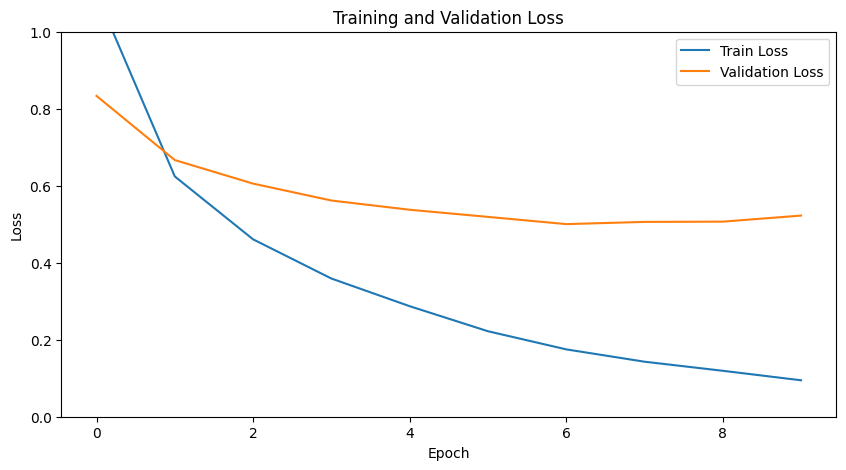

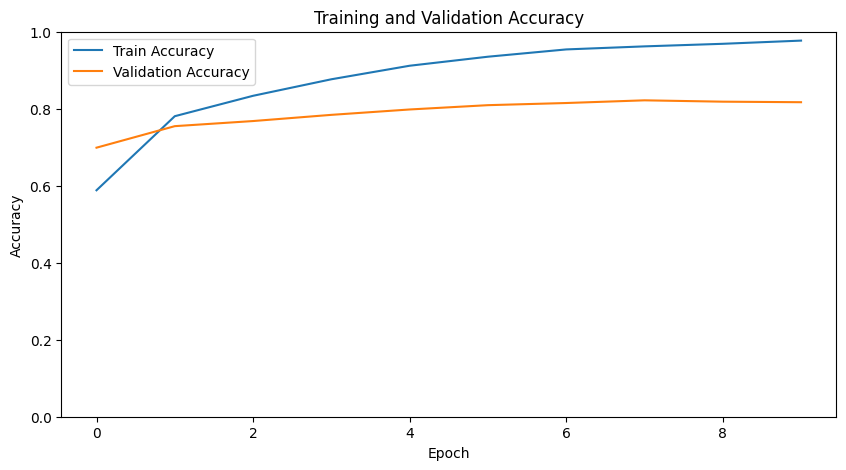

In [6]:
import matplotlib.pyplot as plt

# Get the training history
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim([0, 1])
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0, 1])
plt.show()